<a href="https://colab.research.google.com/github/Svatunek-Lab/teaching/blob/main/2025_University_of_Malaya_Intro_Chemistry_Python/RDkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chemistry in Python

In this section, we explore how chemistry can be represented and analyzed directly in Python using **RDKit**, a popular open-source cheminformatics toolkit.  

We will learn how to:
- **Represent molecules** using text-based notations such as **SMILES**, which uniquely describe chemical structures.  
- **Visualize molecules** in both **2D** (for structural formulas) and **3D** (for spatial geometry and conformers).  
- **Calculate molecular descriptors**, such as molecular weight, logP, or polar surface area, which quantify chemical and physical properties.  
- **Convert molecules into data**, preparing them for further analysis or **machine learning** workflows.  

By the end of this section, you will understand how to represent and analyze molecules directly in Python.


## Setup and Preparation

Before we begin, we need to install a few essential packages:  
**RDKit** for chemical structure handling and basic computations,  
and **py3Dmol** for interactive 3D visualization of molecules.  

Once these are installed, we are ready to start exploring and visualizing real molecular structures in Python.



In [1]:
!pip install -q rdkit py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 40.8 MB/s eta 0:00:00


## Molecules as Python Objects

In RDKit, molecules are represented by **`Mol` objects**.  
These objects store all information about the molecule — atoms, bonds, and connectivity — in a form that Python can access and manipulate.

A `Mol` object can be created from a **SMILES** string, which encodes the structure as plain text.  
Once created, we can inspect its properties or visualize it directly.

In the next example, we will:
1. Create a molecule from its SMILES representation.  
2. Check how many atoms and bonds it contains.  
3. Display its 2D structure.


In [2]:
from rdkit import Chem

# create mol object from SMILES
mol = Chem.MolFromSmiles("O=C(OC1CC=CCC1)C")


In [3]:
print(type(mol))

<class 'rdkit.Chem.rdchem.Mol'>


In [4]:
print(mol.GetNumAtoms(), "atoms")
print(mol.GetNumBonds(), "bonds")

10 atoms
10 bonds


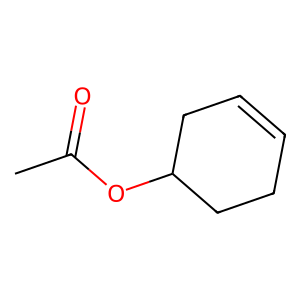

In [5]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

## Substructure search (SMARTS) and highlighting

A powerful feature of RDKit is **substructure search**: finding a pattern (functional group, ring, motif) inside a molecule.

- Patterns are written as **SMARTS** (like regex for molecules).
- Create a query with `Chem.MolFromSmarts(...)`.
- Find all occurrences with `mol.GetSubstructMatches(query)`.
- Highlight the matched atoms/bonds when drawing.

Below, we search for a **carbonyl group** and highlight every match.


Matches found: 1
((3, 4),)


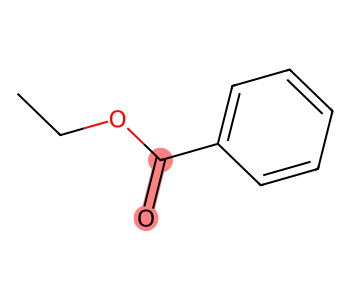

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

# Example molecule (ethyl benzoate)
mol = Chem.MolFromSmiles("CCOC(=O)c1ccccc1")

# SMARTS for a generic carbonyl C=O (sp2 carbonyl carbon)
query = Chem.MolFromSmarts("[CX3]=[OX1]")

matches = mol.GetSubstructMatches(query)  # tuple of atom-index tuples
print(f"Matches found: {len(matches)}")
print(matches)

# Collect atom and bond indices to highlight
highlight_atoms = set(a for m in matches for a in m)
highlight_bonds = []
for m in matches:
    # map query bonds to target bonds to highlight them too
    for qb in query.GetBonds():
        a1 = m[qb.GetBeginAtomIdx()]
        a2 = m[qb.GetEndAtomIdx()]
        b = mol.GetBondBetweenAtoms(a1, a2)
        if b is not None:
            highlight_bonds.append(b.GetIdx())

img = Draw.MolToImage(
    mol,
    size=(350, 300),
    kekulize=True,
    highlightAtoms=list(highlight_atoms),
    highlightBonds=highlight_bonds,
)
img


In [7]:
print(type(query))

<class 'rdkit.Chem.rdchem.Mol'>


### Searching a list of molecules

We can filter a small “library” to those that **contain** a motif and show them side-by-side.


Molecules containing a carbonyl: 4 / 5


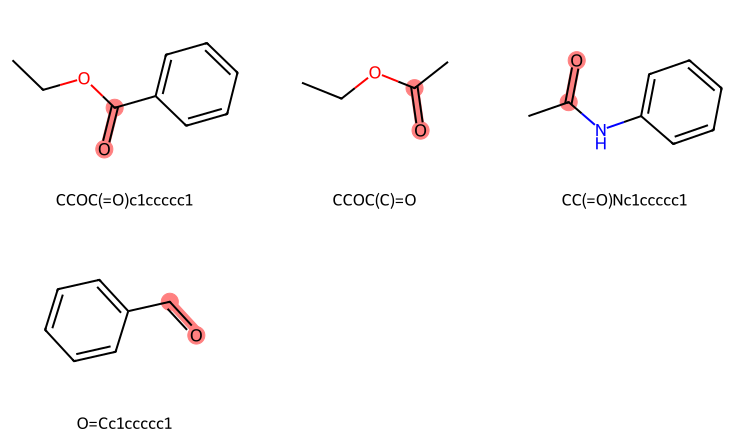

In [10]:
from rdkit.Chem import Draw

smis = [
    "CCOC(=O)c1ccccc1",   # ethyl benzoate
    "CC(=O)OCC",          # ethyl acetate
    "CCO",                # ethanol (no carbonyl)
    "O=C(Nc1ccccc1)C",    # acetanilide
    "c1ccccc1C=O",        # benzaldehyde
]

mols = [Chem.MolFromSmiles(s) for s in smis]
query = Chem.MolFromSmarts("[CX3]=[OX1]")  # carbonyl

hits = []
highlight_atom_lists = []
highlight_bond_lists = []

for m in mols:
    ms = m.GetSubstructMatches(query)
    if not ms:
        continue
    hits.append(m)
    # prepare highlights for each molecule (grid accepts list-of-lists)
    ha = set(a for match in ms for a in match)
    hb = []
    for match in ms:
        for qb in query.GetBonds():
            a1 = match[qb.GetBeginAtomIdx()]
            a2 = match[qb.GetEndAtomIdx()]
            b = m.GetBondBetweenAtoms(a1, a2)
            if b is not None:
                hb.append(b.GetIdx())
    highlight_atom_lists.append(list(ha))
    highlight_bond_lists.append(hb)

print(f"Molecules containing a carbonyl: {len(hits)} / {len(mols)}")

grid = Draw.MolsToGridImage(
    hits,
    molsPerRow=3,
    subImgSize=(250, 220),
    legends=[Chem.MolToSmiles(m) for m in hits],
    highlightAtomLists=highlight_atom_lists,
    highlightBondLists=highlight_bond_lists,
    useSVG=False,
)
grid


## From 2D (SMILES) to 3D (conformer)

Goal: start from a SMILES string, generate a **3D conformer**, perform a quick **geometry optimization**, and **view** it interactively.

Steps:
1) Create `Mol` from SMILES and **add hydrogens** (needed for sensible 3D).  
2) **Embed** a 3D conformer using ETKDG (knowledge-based distances).  
3) **Optimize** with a simple force field (UFF or MMFF).  
4) Visualize with **py3Dmol**.

Notes:
- ETKDG gives good initial geometries.  
- Use **MMFF** if parameters are available; fall back to **UFF** otherwise.  
- You can generate **multiple conformers** to sample geometry.


In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem

# 1) Start from SMILES (ethyl benzoate here)
smiles = "CCOC(=O)c1ccccc1"
mol2d = Chem.MolFromSmiles(smiles)

# 2) Add hydrogens and embed a 3D conformer
mol3d = Chem.AddHs(mol2d)
AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())  # ETKDG embedding

# 3) Optimize geometry with MMFF
AllChem.MMFFOptimizeMolecule(mol3d)




0

In [12]:
# 4) show 3D coordinates

conf = mol3d.GetConformer()

for atom in mol3d.GetAtoms():
    pos = conf.GetAtomPosition(atom.GetIdx())
    print(f"{atom.GetSymbol():<2} {pos.x:12.6f} {pos.y:12.6f} {pos.z:12.6f}")


C      3.432618    -0.437846    -0.781325
C      2.727452     0.835823    -0.354522
O      1.305317     0.671307    -0.455292
C      0.695403     0.134900     0.631323
O      1.246824    -0.215420     1.662758
C     -0.771267     0.018523     0.404568
C     -1.558854    -0.517998     1.432838
C     -2.939399    -0.648348     1.268833
C     -3.540815    -0.244043     0.077877
C     -2.765150     0.290589    -0.950374
C     -1.383421     0.422656    -0.790100
H      4.517957    -0.304413    -0.765002
H      3.172952    -1.271044    -0.120679
H      3.127008    -0.726024    -1.792512
H      3.023633     1.139470     0.656170
H      3.003202     1.652883    -1.029244
H     -1.098913    -0.836785     2.366526
H     -3.544061    -1.065284     2.070519
H     -4.615974    -0.345867    -0.049202
H     -3.236341     0.605169    -1.878484
H     -0.798171     0.841753    -1.604677


In [13]:
# 5) Visualize in 3D
import py3Dmol
mb = Chem.MolToMolBlock(mol3d)
view = py3Dmol.view(width=400, height=350)
view.addModel(mb, "mol")
view.setStyle({"stick": {"radius": 0.15}, "sphere": {"scale": 0.25}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Calculating Molecular Properties

RDKit can calculate many **molecular descriptors** — numerical properties derived from structure.  
These include:
- **Physicochemical properties** (e.g., molecular weight, logP, polar surface area)
- **Structure counts** (e.g., number of rings, rotatable bonds, hydrogen bond donors/acceptors)
- **Topological indices** (e.g., molecular complexity, connectivity descriptors)

Descriptors are useful for:
- Comparing molecules  
- Creating datasets for **machine learning**  
- Screening and filtering chemical libraries


In [14]:
from rdkit.Chem import Descriptors

# Using the 3D-optimized molecule from before
mol = mol3d

props = {
    "Molecular Weight": Descriptors.MolWt(mol),
    "logP": Descriptors.MolLogP(mol),
    "TPSA (Å²)": Descriptors.TPSA(mol),
    "HBD (donors)": Descriptors.NumHDonors(mol),
    "HBA (acceptors)": Descriptors.NumHAcceptors(mol),
    "Rotatable Bonds": Descriptors.NumRotatableBonds(mol),
}

for name, value in props.items():
    print(f"{name:<20}: {value:8.3f}")


Molecular Weight    :  150.177
logP                :    1.863
TPSA (Å²)           :   26.300
HBD (donors)        :    0.000
HBA (acceptors)     :    2.000
Rotatable Bonds     :    3.000


## Lipinski’s Rule of Five

**Goal:** Quick oral bioavailability screen.

A molecule is likely to be orally bioavailable if it does **not** violate more than **one** of the following:

- Molecular weight ≤ **500**
- logP (octanol/water) ≤ **5**
- Hydrogen bond donors (HBD) ≤ **5**
- Hydrogen bond acceptors (HBA) ≤ **10**

**Common extension (Veber):**
- Polar surface area (TPSA) ≤ **140 Å²**
- Rotatable bonds ≤ **10**

We will calculate these properties with RDKit and report **PASS/FAIL**.


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Example molecules (now including Cyclosporine A)
smiles_list = {
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Caffeine": "Cn1cnc2c(N)ncnc12",
    "Ethanol": "CCO",
    "Ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "Lidocaine": "CCN(CC)CCOC(=O)c1ccccc1",
    "Cholesterol": "C[C@H](CCC(=O)O)C1CCC2C3CCC4=CC(O)CCC4(C)C3CC[C@]21C",
    "Cyclosporine A": "CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C"
}

def lipinski_report(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    violations = sum([
        mw > 500,
        logp > 5,
        hbd > 5,
        hba > 10
    ])
    status = "PASS" if violations <= 1 else "FAIL"
    return mw, logp, hbd, hba, violations, status

print(f"{'Molecule':<15} {'MW':>8} {'logP':>8} {'HBD':>5} {'HBA':>5} {'Viol.':>6} {'Result':>8}")
print("-" * 60)
for name, smi in smiles_list.items():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"{name:<15}  (invalid SMILES)")
        continue
    mw, logp, hbd, hba, viol, res = lipinski_report(mol)
    print(f"{name:<15} {mw:8.1f} {logp:8.2f} {hbd:5d} {hba:5d} {viol:6d} {res:>8}")


Molecule              MW     logP   HBD   HBA  Viol.   Result
------------------------------------------------------------
Aspirin            180.2     1.31     1     3      0     PASS
Caffeine           149.2    -0.05     1     5      0     PASS
Ethanol             46.1    -0.00     1     1      0     PASS
Ibuprofen          206.3     3.07     1     1      0     PASS
Lidocaine          221.3     2.19     0     3      0     PASS
Cholesterol        374.6     5.43     2     2      1     PASS
Cyclosporine A    1202.6     3.27     5    12      2     FAIL


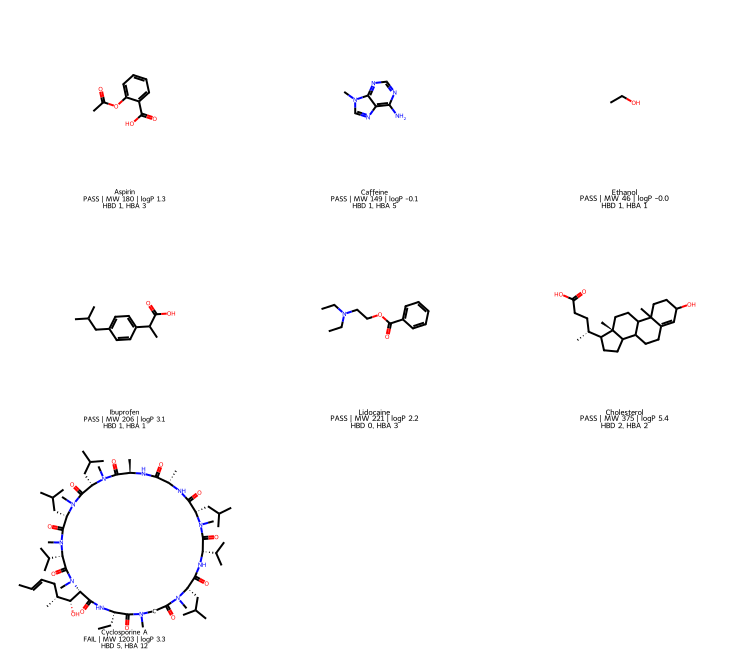

In [ ]:
from rdkit.Chem import Draw

mols, legends = [], []

for name, smi in smiles_list.items():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    mw, logp, hbd, hba, viol, res = lipinski_report(mol)
    mols.append(mol)
    legends.append(
        f"{name}\n{res} | MW {mw:.0f} | logP {logp:.1f}\nHBD {hbd}, HBA {hba}"
    )

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(250, 220),
    legends=legends,
    useSVG=False
)
img


### Getting Chemical Data from the CACTUS Resolver

Sometimes we just want to quickly turn a *chemical name* or *CAS number* into a structure we can use in Python.  
The [**CACTUS Chemical Identifier Resolver**](https://cactus.nci.nih.gov/chemical/structure) from the U.S. NCI provides a simple web API that converts identifiers to formats like **SMILES**, **InChI**, or **molecular formulas** — no API key or setup required.

For example, visiting this link directly in your browser returns the SMILES for acetone:  
 [https://cactus.nci.nih.gov/chemical/structure/acetone/smiles](https://cactus.nci.nih.gov/chemical/structure/acetone/smiles)

We can use the same idea in Python with `requests` to fetch the SMILES and display the molecule.


64-17-5 → CCO


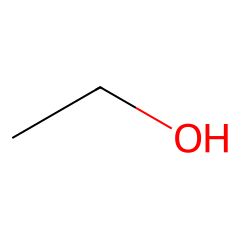

In [28]:
import requests
from rdkit import Chem
from rdkit.Chem import Draw

def cactus_smiles(name):
    url = f"https://cactus.nci.nih.gov/chemical/structure/{name}/smiles"
    r = requests.get(url)
    if not r.ok or not r.text.strip():
        print("Not found on CACTUS."); return
    smiles = r.text.strip()
    print(f"{name} → {smiles}")
    return Draw.MolToImage(Chem.MolFromSmiles(smiles), size=(240,240))

# Examples
cactus_smiles("acetone")
# cactus_smiles("benzene")
# cactus_smiles("64-17-5")   # works with CAS too



### Getting 3D Structures (SDF) from CACTUS

CACTUS can also return the **SDF (Structure Data File)** representation of a compound,  
which contains 3D coordinates that we can visualize interactively with **py3Dmol**.

For example, this link returns the 3D SDF for benzene:  
👉 [https://cactus.nci.nih.gov/chemical/structure/benzene/sdf](https://cactus.nci.nih.gov/chemical/structure/benzene/sdf)


In [30]:
import requests, py3Dmol

def cactus_3d(name):
    url = f"https://cactus.nci.nih.gov/chemical/structure/{name}/sdf"
    r = requests.get(url)
    if not r.ok or not r.text.strip():
        print("3D structure not found on CACTUS."); return
    view = py3Dmol.view(width=380, height=320)
    view.addModel(r.text, "sdf")
    view.setStyle({"stick": {"radius": 0.15}, "sphere": {"scale": 0.25}})
    view.zoomTo()
    return view.show()

# Examples:
cactus_3d("acetone")
# cactus_3d("benzene")
# cactus_3d("64-17-5")   # ethanol CAS


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Getting Experimental Data from PubChem (PUG-View)

While **CACTUS** is perfect for quick identifier lookups,  
**PubChem’s PUG-View API** provides access to **curated experimental data** such as boiling points, densities, and spectral information.

For example, this PUG-View endpoint returns a structured JSON record for acetone:  
👉 [https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/180/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/180/JSON)

We can inspect this JSON and programmatically search for the section labeled **“Boiling Point”**  
to extract and display the experimental value directly in Python.




In [37]:
import requests

def _resolve_cid(name_or_cas: str) -> str | None:
    r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name_or_cas}/cids/TXT")
    return r.text.strip().splitlines()[0] if r.ok and r.text.strip() else None

def _first_string_from_info(info: dict) -> str | None:
    v = info.get("Value", {})
    if "StringWithMarkup" in v and v["StringWithMarkup"]:
        return v["StringWithMarkup"][0].get("String")
    if "String" in v:
        return v["String"]
    if "sval" in v:
        return v["sval"]
    if "Number" in v:
        return str(v["Number"])
    return None

def _find_heading(sections: list, heading: str) -> str | None:
    for sec in sections or []:
        if sec.get("TOCHeading", "").lower() == heading.lower():
            for inf in sec.get("Information", []):
                s = _first_string_from_info(inf)
                if s:
                    return s
        s = _find_heading(sec.get("Section"), heading)
        if s:
            return s
    return None

def pubchem_pugview_smiles_and_bp(name_or_cas: str):
    cid = _resolve_cid(name_or_cas)
    if not cid:
        print("Not found on PubChem.")
        return None, None

    j = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON").json()
    sections = j.get("Record", {}).get("Section", [])

    smiles = (_find_heading(sections, "Isomeric SMILES")
              or _find_heading(sections, "Canonical SMILES")
              or _find_heading(sections, "SMILES"))
    bp = _find_heading(sections, "Boiling Point")

    print(f"{name_or_cas} (CID {cid})")
    print("SMILES:", smiles or "—")
    print("Boiling Point:", bp or "not listed")

    # Return both for later use
    return smiles, bp

# Example
smiles_raw, bp_raw = pubchem_pugview_smiles_and_bp("acetone")


acetone (CID 180)
SMILES: CC(=O)C
Boiling Point: 133 °F at 760 mmHg (NTP, 1992)


In [38]:
import re

# bp_raw comes from the previous cell
print("Raw BP value from PubChem:", bp_raw)

if bp_raw:
    # Find numeric temperature and unit (°C or °F)
    m = re.search(r"([-+]?\d+\.?\d*)\s*°?\s*([CF])", bp_raw)
    if m:
        value = float(m.group(1))
        unit = m.group(2).upper()
        if unit == "F":
            c = (value - 32) * 5/9
            print(f"{value:.1f} °F  →  {c:.1f} °C")
        else:
            print(f"{value:.1f} °C (already Celsius)")
    else:
        print("No temperature pattern found in string.")
else:
    print("No BP data available.")


Raw BP value from PubChem: 133 °F at 760 mmHg (NTP, 1992)
133.0 °F  →  56.1 °C


### Similarity and Shared Structure (ECFP4/Tanimoto + MCS)

In this part, we:
1) Built a **Morgan (ECFP4)** fingerprint for a target molecule and printed the bit vector.  
2) **Visualized** similarity as bit overlap and computed the **Tanimoto** score.  
3) Highlighted the **Maximum Common Substructure (MCS)** to show which atoms/bonds are shared between two molecules.

Takeaway: more overlapping fingerprint bits → higher Tanimoto; the MCS shows *where* that similarity comes from.


In [55]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Define target molecule
acetone_name = "Acetone"
acetone_smiles = "CC(=O)C"
acetone_mol = Chem.MolFromSmiles(acetone_smiles)

# Create Morgan fingerprint generator (radius 2 ≈ ECFP4)
acetone_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=128)

# Generate the fingerprint
acetone_fp = acetone_gen.GetFingerprint(acetone_mol)

# Convert to binary string for display
acetone_bits = "".join(str(int(b)) for b in acetone_fp)

# Print information
print(f"{acetone_name} ({acetone_smiles})")
print(f"Fingerprint length: {len(acetone_bits)} bits")
print("Fingerprint:")
print(acetone_bits)

Acetone (CC(=O)C)
Fingerprint length: 128 bits
Fingerprint:
00000000001001000000000000000000010000010000000000000000000000000000000000000000000000000000000000000000000000000000000001000100


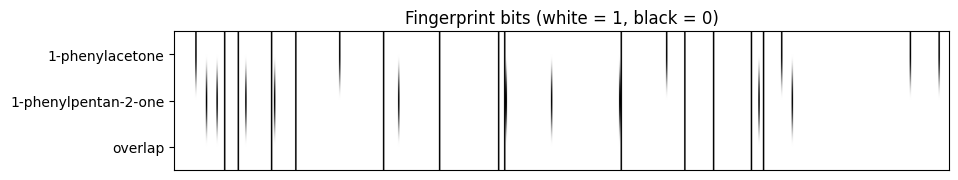

In [56]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt

# Molecules
name_a, smi_a = "1-phenylacetone", "CC(=O)Cc1ccccc1"
name_b, smi_b = "1-phenylpentan-2-one", "CCC(=O)CCc1ccccc1"
mol_a, mol_b = Chem.MolFromSmiles(smi_a), Chem.MolFromSmiles(smi_b)

# Morgan (ECFP4) fingerprints
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=512)
fp_a = gen.GetFingerprint(mol_a)
fp_b = gen.GetFingerprint(mol_b)

# Get FP size from one fingerprint
fp_size = fp_a.GetNumBits()

# Convert to NumPy arrays
arr_a = np.zeros((fp_size,), dtype=int); DataStructs.ConvertToNumpyArray(fp_a, arr_a)
arr_b = np.zeros((fp_size,), dtype=int); DataStructs.ConvertToNumpyArray(fp_b, arr_b)
arr_overlap = (arr_a & arr_b)

# Plot
fig, ax = plt.subplots(figsize=(10, 1.8))
img = np.vstack([arr_a, arr_b, arr_overlap])
ax.imshow(img, aspect="auto", cmap="Greys")
ax.set_yticks([0, 1, 2]); ax.set_yticklabels([name_a, name_b, "overlap"])
ax.set_xticks([])
ax.set_title("Fingerprint bits (white = 1, black = 0)")
plt.show()


In [54]:
from rdkit import DataStructs

on_a = int(arr_a.sum())
on_b = int(arr_b.sum())
on_ab = int(arr_overlap.sum())

tani = DataStructs.TanimotoSimilarity(fp_a, fp_b)

print(f"|A| = {on_a}   |B| = {on_b}   |A ∩ B| = {on_ab}")
den = on_a + on_b - on_ab
print(f"Tanimoto = |A ∩ B| / (|A| + |B| − |A ∩ B|) = {on_ab} / {den} = {tani:.2f}")


|A| = 19   |B| = 23   |A ∩ B| = 13
Tanimoto = |A ∩ B| / (|A| + |B| − |A ∩ B|) = 13 / 29 = 0.45


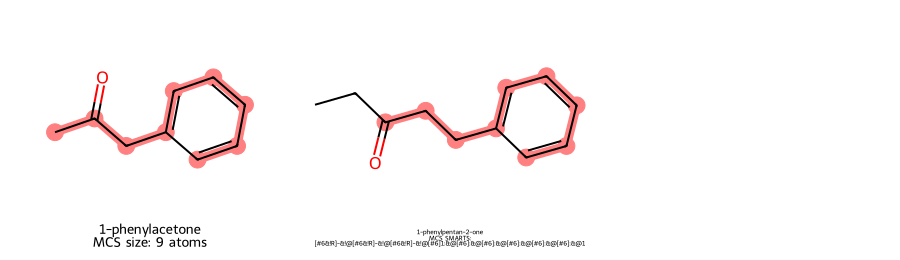

In [57]:
from rdkit.Chem import rdFMCS, Draw


# Find Maximum Common Substructure
mcs = rdFMCS.FindMCS(
    [mol_a, mol_b],
    ringMatchesRingOnly=True,      # avoid breaking rings
    completeRingsOnly=False,
    matchValences=True,
    timeout=5
)

mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)

# Map MCS to both molecules (get atom & bond indices to highlight)
match_a = mol_a.GetSubstructMatch(mcs_mol)
match_b = mol_b.GetSubstructMatch(mcs_mol)

bonds_a = []
for i,j in zip(match_a, match_a[1:]):  # collect bonds along matched path
    b = mol_a.GetBondBetweenAtoms(i,j)
    if b: bonds_a.append(b.GetIdx())

bonds_b = []
for i,j in zip(match_b, match_b[1:]):
    b = mol_b.GetBondBetweenAtoms(i,j)
    if b: bonds_b.append(b.GetIdx())

# Draw side-by-side with MCS highlighted
img = Draw.MolsToGridImage(
    [mol_a, mol_b],
    legends=[f"{name_a}\nMCS size: {mcs.numAtoms} atoms", f"{name_b}\nMCS SMARTS:\n{mcs_smarts}"],
    highlightAtomLists=[list(match_a), list(match_b)],
    highlightBondLists=[bonds_a, bonds_b],
    subImgSize=(300,260),
    useSVG=False
)
img


### Comparing Multiple Molecules

Now that we understand how molecular similarity works,  
we will compare several compounds to our **target molecule** and sort them by their **Tanimoto similarity**.  
This shows how fingerprints can be used to rank molecules based on structural resemblance.


,name,smiles,tanimoto
0,propanone (acetone),CC(=O)C,1.000000
1,acetic acid,CC(=O)O,0.625000
2,2-pentanone,CCC(=O)CC,0.333333
3,ethyl acetate,CCOC(=O)C,0.333333
4,2-propanol,CC(O)C,0.200000
5,cyclohexanone,O=C1CCCCC1,0.062500
6,benzaldehyde,O=CC1=CC=CC=C1,0.052632


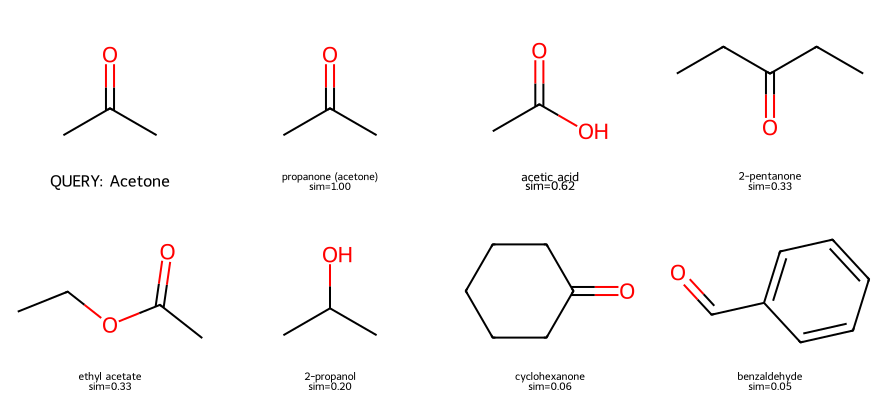

In [59]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Draw
from rdkit import DataStructs
import pandas as pd

# --- Target ---
target_name = "Acetone"
target_smiles = "CC(=O)C"
target_mol = Chem.MolFromSmiles(target_smiles)

# --- Library ---
library = {
    "propanone (acetone)": "CC(=O)C",
    "2-pentanone": "CCC(=O)CC",
    "2-propanol": "CC(O)C",
    "ethyl acetate": "CCOC(=O)C",
    "cyclohexanone": "O=C1CCCCC1",
    "benzaldehyde": "O=CC1=CC=CC=C1",
    "acetic acid": "CC(=O)O",
}

# --- Fingerprints and similarities ---
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
qfp = gen.GetFingerprint(target_mol)

rows = []
for name, smi in library.items():
    m = Chem.MolFromSmiles(smi)
    fp = gen.GetFingerprint(m)
    sim = DataStructs.TanimotoSimilarity(qfp, fp)
    rows.append({"name": name, "smiles": smi, "mol": m, "sim": sim})

# --- Sort by similarity (desc) ---
rows_sorted = sorted(rows, key=lambda r: r["sim"], reverse=True)

# --- Build grid content in the SAME order as legends ---
grid_mols = [target_mol] + [r["mol"] for r in rows_sorted]
legends   = [f"QUERY: {target_name}"] + [f"{r['name']}\nsim={r['sim']:.2f}" for r in rows_sorted]

# Optional: show table
df = pd.DataFrame(
    [{"name": r["name"], "smiles": r["smiles"], "tanimoto": r["sim"]} for r in rows_sorted]
)
display(df)

# --- Draw grid ---
img = Draw.MolsToGridImage(
    grid_mols,
    legends=legends,
    molsPerRow=4,
    subImgSize=(220, 200),
    useSVG=False
)
img
